# Setting up Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import os
import csv

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Simulating Early Data for Instruments Lacking

0 FLOW.csv
                Open      High       Low     Close Adj Close   Volume
Date                                                                 
2017-11-09  0.617684    1.0414  0.506469  0.704331  0.703385  96115.5
2017-11-10   0.74113  0.998883  0.509125  0.597987  0.595111  35048.2
2017-11-11  0.627116  0.880703  0.487586  0.588388  0.602089  28631.6
2017-11-12  0.617152  0.812567  0.426042  0.514735  0.526162  37329.8
2017-11-13  0.547342  0.772536  0.444365  0.554383  0.566342  23050.2
1 MANA.csv
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2017-11-09  0.014329  0.016111  0.013886  0.015130   0.015130  653800
2017-11-10  0.015162  0.015734  0.012645  0.012940   0.012940  296429
2017-11-11  0.013201  0.013616  0.011758  0.011979   0.011979  237865
2017-11-12  0.011975  0.011975  0.010125  0.010505   0.010505  242761
2017-11-13  0.010628  0.011660  0.010628  0.011330   0.011330  22583

/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/var/folders/9q/fqr5tk052lsc8fhj38wpb4_80000gp/T/ipykernel_11466/2347088520.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early_df.iloc[0] = fd
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

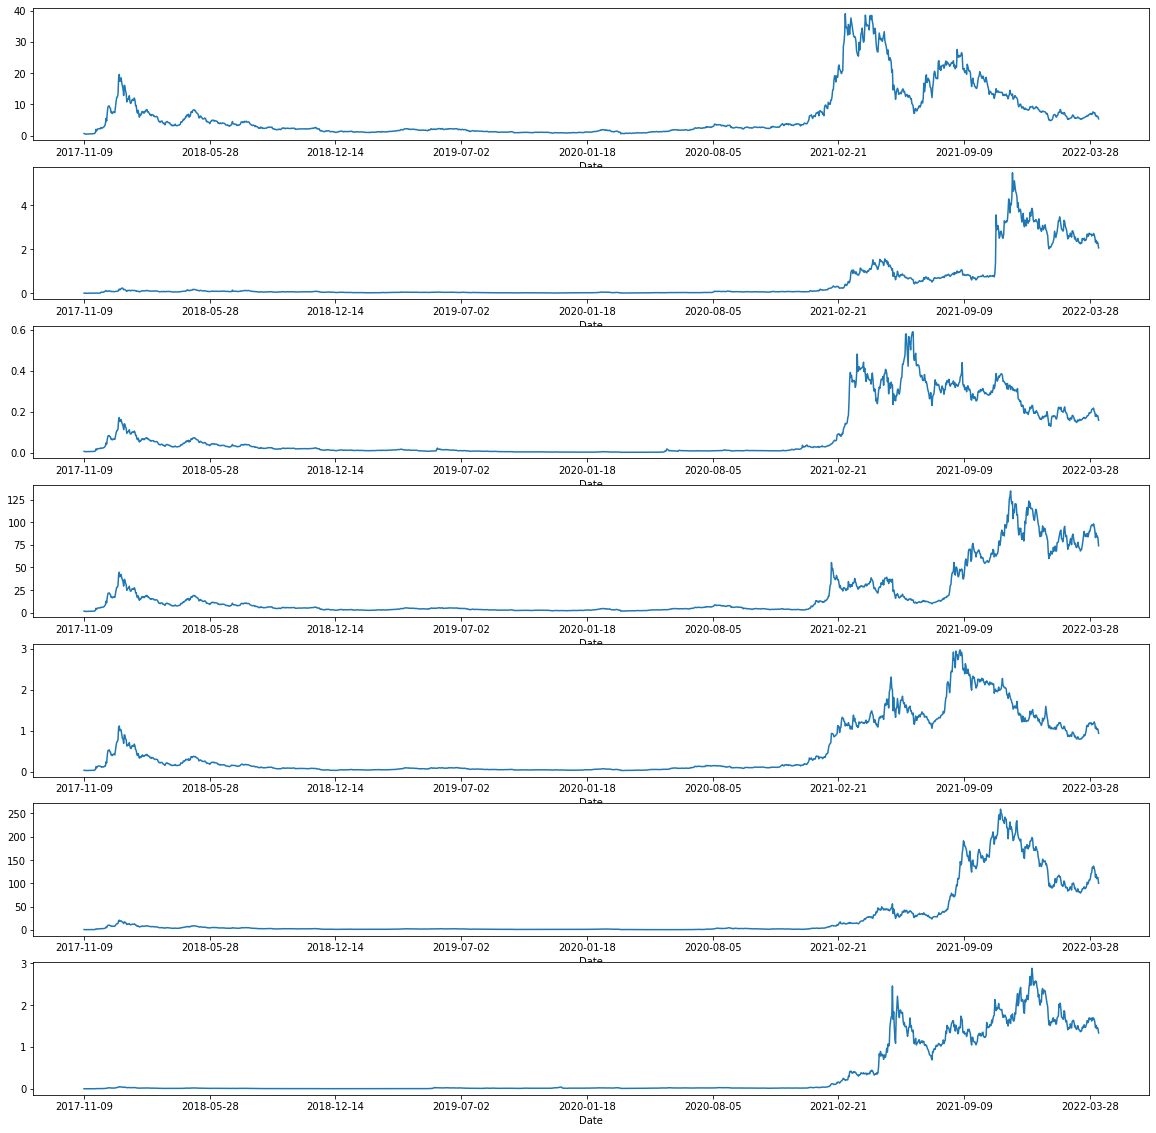

In [2]:
# .csvs downloaded from Yahoo Finance
path = "../data/instruments"
fig, ax = plt.subplots(7, figsize=(20,20))

ada_df = pd.read_csv("../data/instruments/ADA.csv")
dates = ada_df['Date']

mana_df = pd.read_csv("../data/instruments/MANA.csv")

ada_df['Open'] = np.mean((mana_df['Open'], ada_df['Open']), axis=0) 
ada_df['High'] = np.mean((mana_df['High'], ada_df['High']), axis=0)
ada_df['Low'] = np.mean((mana_df['Low'], ada_df['Low']), axis=0) 
ada_df['Close'] = np.mean((mana_df['Close'], ada_df['Close']), axis=0) 
ada_df['Volume'] = np.mean((mana_df['Volume'], ada_df['Volume']), axis=0)

i = 0
for fn in os.listdir(path):
    print(i, fn)
    df = pd.read_csv(os.path.join(path, fn))
    
    # simulating earlier data for those without
    df = df.set_index("Date")
    first_date = df.index[0]
    
    # first day percentages
    fd_perc = ada_df.iloc[0,1:]/ada_df[ada_df["Date"] ==first_date].iloc[0,1:]
    
    if first_date > ada_df['Date'][0]:
        fd = fd_perc*df.iloc[0, :]
        
        # inverse pctchange
        pctchg = ada_df.set_index("Date", drop=True).pct_change()
        inversed_pctchg = (1+pctchg).cumprod()*fd
        early_df = inversed_pctchg[inversed_pctchg.index < first_date]
        
        # replace first missing row
        early_df.iloc[0] = fd
        
        # concat early values
        concat = pd.concat((early_df[early_df.index < first_date], df))
        df = concat
        
    # plot
    _ = df['Close'].plot(ax=ax[i])    
    
    df.to_csv(os.path.join("../data/instruments_modified", fn))
    
    i += 1
    print(df.head())

## Creating a Bundle

In [182]:
# https://github.com/aspromatis/zipline_bundle/blob/master/prepare_bundle.py
# Assuming crypto

def format_bundle(indir, outdir):
       
    count = 0
    for f in os.listdir(indir): # For Production
    # for f in ['AAPL.csv']:  # For Testing
        if f[-4:] != '.csv':
            continue
        
        df = pd.read_csv(os.path.join(indir,f), index_col='Date')
        
        # trading days will be the same 
        #df = df.reindex(trading_days)

        # Export it in the csvdir format needed for the zipline bundle ingestion process
        df.reset_index(inplace=True)
        
        # drop adj close column
        df.drop('Adj Close', axis=1, inplace=True)
        
        # Check if there is there is any dividend, if not make it zero
        if not 'dividend' in df.columns:
            df['dividend'] = 0.0
        
        # Assume the only columns that exist in the .csv are [Date, Open, High, Low, Close, Adj Close, Volume] in that order
        #df = df[['date', 'open_adj', 'high_adj', 'low_adj', 'close_adj', 'volume_adj', 'dividend']]
        
        df['dividend'].fillna(0.00, inplace=True)
        df['ratio'] = 1  # There are no splits
        
        old_colnames = df.columns
        
        df.rename(columns={old_colnames[0]: 'date',
                           old_colnames[1]: 'open',
                           old_colnames[2]: 'high',
                           old_colnames[3]: 'low',
                           old_colnames[4]: 'close',
                           old_colnames[5]: 'volume'
                           }, inplace=True)
        
        # Round the numbers in the dataframe
        # won't work very well for small-cap coins?
        # could put off rounding?
        df = df.round({'open':6,
                  'high':6,
                  'low':6,
                  'close':6,
                  'volume':0,
                  'dividend':2})

        df.to_csv(os.path.join(outdir, f), index=False)

        count += 1
        
    return ('{} files were adjusted'.format(count))

# simulated early data
format_bundle("../data/instruments_modified", "../data/daily")

# non-simulated (mismatching date ranges)
#format_bundle("../data/instruments", "../data/daily")

'7 files were adjusted'